## Imprt Libraries

In [1]:
!pip install gprofiler-official gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 15.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import gzip
import io
import os
from gprofiler import GProfiler
from gseapy import enrichr

# Set random seed for reproducibility
np.random.seed(42)

# Display utilities for Jupyter Notebook
from IPython.display import display

In [3]:
# Step 2: Download STRING PPI file (v11.5, human)
url = 'https://stringdb-static.org/download/protein.links.full.v11.5/9606.protein.links.full.v11.5.txt.gz'
response = requests.get(url)
compressed_file = io.BytesIO(response.content)
with gzip.open(compressed_file, 'rt') as f:
    df = pd.read_csv(f, sep=' ')

# Step 3: Clean and parse STRING protein IDs
df['protein1'] = df['protein1'].str.replace('9606.', '')
df['protein2'] = df['protein2'].str.replace('9606.', '')

# Filter high confidence interactions (optional, score > 700)
df = df[df['combined_score'] > 700]

# Step 4: Map Ensembl protein IDs to HGNC symbols using g:Profiler
gprof = GProfiler(return_dataframe=True)
unique_ids = pd.unique(df[['protein1', 'protein2']].values.ravel('K'))

# Mapping (batch)
mapping = gprof.convert(organism='hsapiens', query=unique_ids.tolist())

# Filter only those that mapped successfully
mapping = mapping[['incoming', 'name']]
id_map = dict(zip(mapping['incoming'], mapping['name']))

# Apply mapping
df['gene1'] = df['protein1'].map(id_map)
df['gene2'] = df['protein2'].map(id_map)

# Remove unmapped
df = df.dropna(subset=['gene1', 'gene2'])

# Step 5: Remove duplicate edges (keep max score)
df_cleaned = df.groupby(['gene1', 'gene2'])['combined_score'].max().reset_index()

# Step 6: Build the graph
G = nx.Graph()
for _, row in df_cleaned.iterrows():
    G.add_edge(row['gene1'], row['gene2'], weight=row['combined_score'])

# Step 7: Extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"Final Graph — Nodes: {G_lcc.number_of_nodes()}, Edges: {G_lcc.number_of_edges()}")

# Step 8: Save as edge list CSV (optional)
nx.write_edgelist(G_lcc, "Data/ppi_network_largest_component.edgelist", data=['weight'])

Final Graph — Nodes: 15908, Edges: 241262


## Import SFARI and Negative Gene sets

In [4]:
ppi_network = nx.read_edgelist("ppi_network_largest_component.edgelist", data=[("weight", float)], nodetype=str)

# Load SFARI dataset
sfari_df = pd.read_csv("Data/SFARI-Gene_genes.csv")

# Load negative genes
negatives_df = pd.read_csv("Data/negative_genes.csv")

# Define positive and negative gene sets based on SFARI
positive_genes = sfari_df[sfari_df['gene-score'].isin(['1','2','3','4']) | sfari_df['syndromic']]['gene-symbol'].tolist()

negative_genes = negatives_df['GeneSym'].tolist()
# Remove positives from negatives
negative_genes = list(set(negative_genes) - set(positive_genes))

# sfari_df
# negative_genes
# positive_genes

In [5]:
## Step 3: Prepare the PPI Network Graph

# The graph has already been constructed and cleaned as `ppi_network`.
print(f"PPI Network - Nodes: {ppi_network.number_of_nodes()}, Edges: {ppi_network.number_of_edges()}")

# Display a few nodes and edges for inspection
print("Sample nodes:", list(ppi_network.nodes)[:5])
print("Sample edges:", list(ppi_network.edges(data=True))[:5])

PPI Network - Nodes: 15908, Edges: 241262
Sample nodes: ['A1BG', 'AKT1', 'CRISP3', 'GAB1', 'GAB2']
Sample edges: [('A1BG', 'AKT1', {'weight': 929.0}), ('A1BG', 'CRISP3', {'weight': 980.0}), ('A1BG', 'GAB1', {'weight': 944.0}), ('A1BG', 'GAB2', {'weight': 972.0}), ('A1BG', 'GAB3', {'weight': 736.0})]


In [6]:
## Step 4: Align SFARI and Negative Genes with the PPI Network and Create Labels

# Load SFARI dataset
sfari = pd.read_csv("Data/SFARI-Gene_genes.csv")

# Filter SFARI genes with gene-score between 1 and 4 or syndromic flagged
sfari_filtered = sfari[(sfari['gene-score'].between(1, 4)) | (sfari['syndromic'] == True)]

# Extract SFARI gene symbols
sfari_genes = set(sfari_filtered['gene-symbol'].str.upper())

# Load negative genes dataset
negatives = pd.read_csv("negative_genes.csv")

# Extract negative gene symbols, convert to uppercase for consistency
negative_genes = set(negatives['GeneSym'].str.upper())

# Network nodes in uppercase for matching
network_genes = set([node.upper() for node in ppi_network.nodes()])

# Intersect SFARI and negative genes with network nodes
sfari_in_network = sfari_genes.intersection(network_genes)
negative_in_network = negative_genes.intersection(network_genes)

print(f"SFARI genes in network: {len(sfari_in_network)}")
print(f"Negative genes in network: {len(negative_in_network)}")

# Create label vector aligned with network nodes order
nodes_list = list(ppi_network.nodes())
nodes_upper = [n.upper() for n in nodes_list]

# Label encoding:
# 1 for SFARI positive genes
# -1 for negative genes
# 0 otherwise (unlabeled)
labels = []
for gene in nodes_upper:
    if gene in sfari_in_network:
        labels.append(1)
    elif gene in negative_in_network:
        labels.append(-1)
    else:
        labels.append(0)

labels = np.array(labels)

print(f"Label distribution: {np.unique(labels, return_counts=True)}")

SFARI genes in network: 1123
Negative genes in network: 2954
Label distribution: (array([-1,  0,  1]), array([ 2643, 12142,  1123]))


In [7]:
import scipy.sparse as sp

# Prepare adjacency matrix from the PPI network
adj = nx.adjacency_matrix(ppi_network, weight='weight')

# Normalize adjacency matrix to create transition matrix M
# M = D^-1 * A where D is the diagonal degree matrix
degrees = np.array(adj.sum(axis=1)).flatten()
D_inv = sp.diags(1.0 / degrees)
M = D_inv.dot(adj)

# Define the random walk with restart function
def random_walk_with_restart(M, seed_vector, restart_prob=0.7, max_iter=100, tol=1e-6):
    """
    Performs random walk with restart on the network.

    Parameters:
    - M: transition matrix (sparse matrix)
    - seed_vector: initial probability vector (numpy array)
    - restart_prob: restart probability (lambda in paper)
    - max_iter: maximum number of iterations
    - tol: convergence tolerance

    Returns:
    - p: final propagated score vector
    """
    p = seed_vector.copy()
    for i in range(max_iter):
        p_new = (1 - restart_prob) * M.dot(p) + restart_prob * seed_vector
        if np.linalg.norm(p_new - p, 1) < tol:
            break
        p = p_new
    return p

# Initialize seed vector from labels:
# For propagation, use positive genes (label=1) as seeds with uniform probability
seed_vector = np.zeros(len(labels))
positive_indices = np.where(labels == 1)[0]
seed_vector[positive_indices] = 1.0 / len(positive_indices)

# Run propagation
propagated_scores = random_walk_with_restart(M, seed_vector, restart_prob=0.7)

# Inspect top scoring genes
top_indices = np.argsort(propagated_scores)[::-1][:20]
top_genes = [list(ppi_network.nodes())[i] for i in top_indices]
top_scores = propagated_scores[top_indices]

print("Top 20 genes by propagated score:")
for gene, score in zip(top_genes, top_scores):
    print(f"{gene}: {score:.4f}")

Top 20 genes by propagated score:
ZBTB21: 0.0009
NXPH1: 0.0009
ZNF532: 0.0009
ZSWIM6: 0.0008
ANKS1B: 0.0008
TANC2: 0.0008
FGF14: 0.0008
NLGN3: 0.0008
MTSS2: 0.0008
CDH22: 0.0008
KLF16: 0.0008
DLGAP2: 0.0008
MARK1: 0.0008
NCKAP5: 0.0008
PHF7: 0.0008
PCDH19: 0.0008
NLGN4X: 0.0008
LRRC4: 0.0008
FEZF2: 0.0008
NLGN1: 0.0008


,restart_prob,mean_auc,std_auc,mean_ap,std_ap
0,0.1,0.698353,0.022157,0.542071,0.012195
1,0.2,0.700057,0.020275,0.545163,0.012825
2,0.3,0.698389,0.018908,0.544389,0.014558
3,0.4,0.694894,0.017505,0.541886,0.015238
4,0.5,0.690635,0.016339,0.539427,0.015547
5,0.6,0.685891,0.015368,0.536732,0.017343
6,0.7,0.681314,0.014543,0.533620,0.018684
7,0.8,0.676999,0.013864,0.530426,0.019353
8,0.9,0.673404,0.013505,0.526664,0.019882


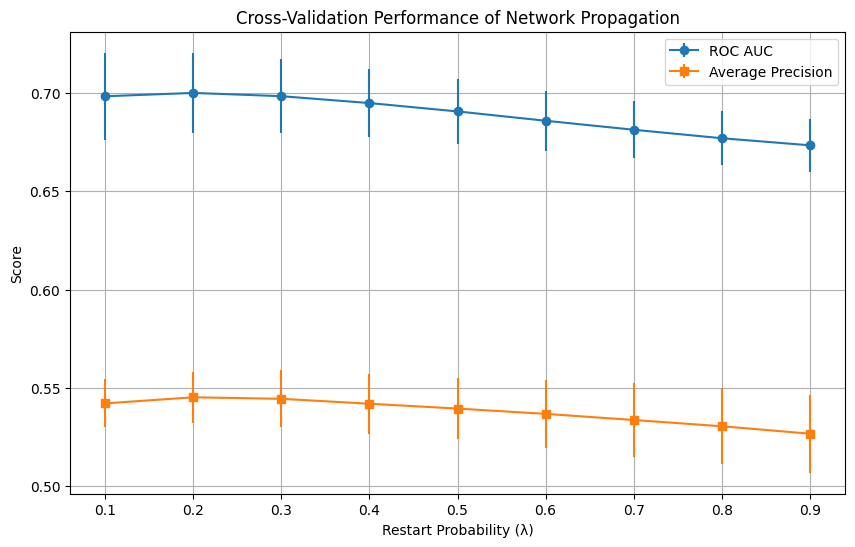

In [8]:
## Step 6: Cross-Validation and Performance Evaluation

from sklearn.metrics import roc_auc_score, average_precision_score

# Prepare for stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We will evaluate over a range of restart probabilities (lambda)
lambda_values = np.arange(0.1, 1.0, 0.1)

cv_results = []

for restart_prob in lambda_values:
    fold_aucs = []
    fold_aps = []

    for train_idx, test_idx in skf.split(np.zeros(len(labels)), labels):
        # Seed vector: only positive genes in training set get initial seeds
        seed_vector = np.zeros(len(labels))
        train_positives = [i for i in train_idx if labels[i] == 1]
        if len(train_positives) == 0:
            continue
        seed_vector[train_positives] = 1.0 / len(train_positives)

        # Run propagation
        scores = random_walk_with_restart(M, seed_vector, restart_prob=restart_prob)

        # Evaluate on test set (only positives and negatives)
        test_pos_neg = [i for i in test_idx if labels[i] != 0]
        if len(test_pos_neg) == 0:
            continue

        y_true = labels[test_pos_neg]
        y_scores = scores[test_pos_neg]

        # Convert labels: positive=1, negative=0 for metrics
        y_true_bin = (y_true == 1).astype(int)

        # Compute metrics
        auc = roc_auc_score(y_true_bin, y_scores)
        ap = average_precision_score(y_true_bin, y_scores)

        fold_aucs.append(auc)
        fold_aps.append(ap)

    # Aggregate fold results
    cv_results.append({
        'restart_prob': restart_prob,
        'mean_auc': np.mean(fold_aucs),
        'std_auc': np.std(fold_aucs),
        'mean_ap': np.mean(fold_aps),
        'std_ap': np.std(fold_aps)
    })

# Convert to DataFrame for easy visualization
cv_df = pd.DataFrame(cv_results)
display(cv_df)

# Plot performance metrics vs restart probability
plt.figure(figsize=(10,6))
plt.errorbar(cv_df['restart_prob'], cv_df['mean_auc'], yerr=cv_df['std_auc'], label='ROC AUC', marker='o')
plt.errorbar(cv_df['restart_prob'], cv_df['mean_ap'], yerr=cv_df['std_ap'], label='Average Precision', marker='s')
plt.xlabel('Restart Probability (λ)')
plt.ylabel('Score')
plt.title('Cross-Validation Performance of Network Propagation')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
## Step 7: Enrichment Analysis of Top-Ranked Genes Using Reactome

import json

def enrichr_reactome_enrichment(gene_list, top_k=100):
    """
    Perform Reactome pathway enrichment analysis using Enrichr API.

    Parameters:
    - gene_list: list of gene symbols (strings)
    - top_k: number of top genes to analyze

    Returns:
    - enrichment_df: DataFrame with Reactome enrichment results
    """
    ENRICHR_ADD_URL = 'https://maayanlab.cloud/Enrichr/addList'
    ENRICHR_ENRICH_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    gene_str = '\n'.join(gene_list[:top_k])

    # Step 1: Submit gene list
    payload = {'list': (None, gene_str)}
    response = requests.post(ENRICHR_ADD_URL, files=payload)
    if not response.ok:
        raise Exception('Error adding gene list to Enrichr')

    data = response.json()
    user_list_id = data['userListId']

    # Step 2: Query Reactome 2022 enrichment results
    params = {'userListId': user_list_id, 'backgroundType': 'Reactome_2022'}
    response = requests.get(ENRICHR_ENRICH_URL, params=params)
    if not response.ok:
        raise Exception('Error fetching Reactome enrichment results')

    results = response.json()['Reactome_2022']

    # Convert results to DataFrame
    columns = ['Rank', 'Term', 'P-value', 'Z-score', 'Combined Score', 'Genes', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value']
    enrichment_df = pd.DataFrame(results, columns=columns)

    return enrichment_df

# Extract top 100 genes by propagated score
top_genes = [nodes_list[i] for i in np.argsort(propagated_scores)[::-1][:100]]

# Perform enrichment analysis
reactome_enrichment_results = enrichr_reactome_enrichment(top_genes)

# Display top enriched pathways
display(reactome_enrichment_results.head(10))

,Rank,Term,P-value,Z-score,Combined Score,Genes,Adjusted P-value,Old P-value,Old Adjusted P-value
0,1,Neuronal System R-HSA-112316,6.130570e-32,27.273730,1960.147609,"[NLGN3, NLGN1, NLGN2, NRXN1, GRIK5, NRXN3, GRI...",7.969741e-30,0,0
1,2,Protein-protein Interactions At Synapses R-HSA...,3.874146e-30,78.687512,5328.972272,"[NLGN3, NLGN1, NLGN2, NLGN4X, HOMER1, NRXN1, N...",2.518195e-28,0,0
2,3,Neurexins And Neuroligins R-HSA-6794361,2.164322e-26,101.692771,6009.544990,"[NLGN3, NLGN1, NLGN2, NLGN4X, HOMER1, NRXN1, N...",9.378731e-25,0,0
3,4,Transmission Across Chemical Synapses R-HSA-11...,1.455569e-12,15.025974,409.542306,"[GRIK5, CACNA2D3, GRIK3, CASK, GRIK4, LIN7B, S...",4.730598e-11,0,0
4,5,Dopamine Neurotransmitter Release Cycle R-HSA-...,1.448708e-11,93.540323,2334.557315,"[RIMS1, PPFIA1, CASK, LIN7B, SYN2, TSPOAP1, PP...",3.766640e-10,0,0
5,6,Neurotransmitter Release Cycle R-HSA-112310,5.288019e-09,34.758440,662.420162,"[RIMS1, PPFIA1, CASK, SYN2, LIN7B, TSPOAP1, PP...",1.145737e-07,0,0
6,7,Serotonin Neurotransmitter Release Cycle R-HSA...,2.298253e-08,80.514170,1416.126002,"[RIMS1, PPFIA1, SYN2, TSPOAP1, PPFIA3]",4.268185e-07,0,0
7,8,Acetylcholine Neurotransmitter Release Cycle R...,1.331900e-06,63.740385,862.337567,"[RIMS1, PPFIA1, TSPOAP1, PPFIA3]",2.164337e-05,0,0
8,9,Norepinephrine Neurotransmitter Release Cycle ...,1.705881e-06,59.184524,786.055048,"[RIMS1, PPFIA1, TSPOAP1, PPFIA3]",2.464050e-05,0,0
9,10,Neurotransmitter Receptors And Postsynaptic Si...,3.675918e-06,9.858071,123.361019,"[ARHGEF9, GRIK5, TSPAN7, GRIK3, CASK, GRIK4, L...",4.778693e-05,0,0


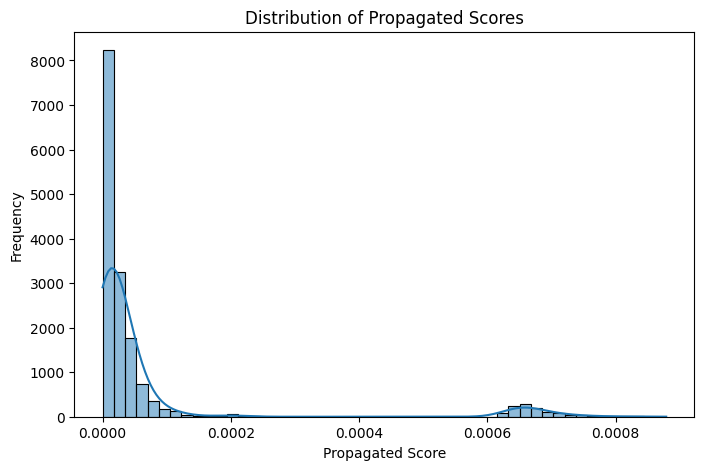

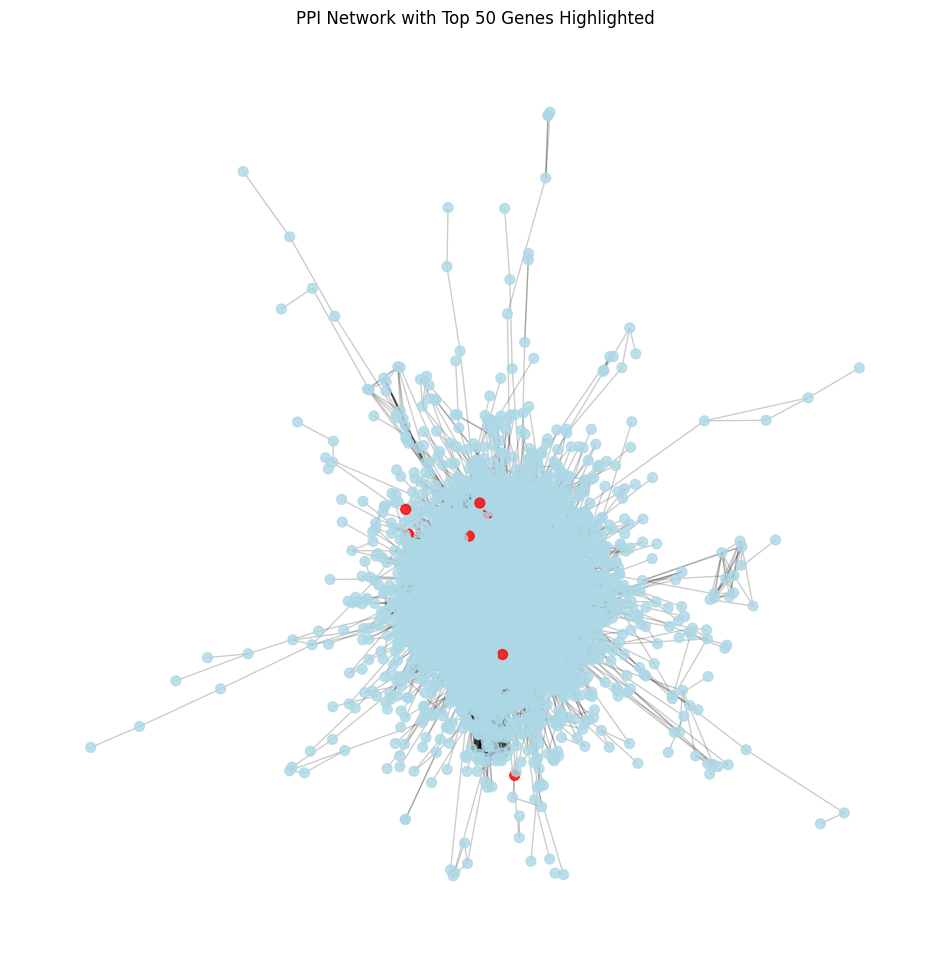

In [10]:
## Step 8: Visualization of Network and Propagation Scores

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of propagated scores
plt.figure(figsize=(8,5))
sns.histplot(propagated_scores, bins=50, kde=True)
plt.title('Distribution of Propagated Scores')
plt.xlabel('Propagated Score')
plt.ylabel('Frequency')
plt.show()

# Visualize the PPI network highlighting top scoring genes
top_k = 50
top_indices = np.argsort(propagated_scores)[-top_k:]
top_nodes = [nodes_list[i] for i in top_indices]

# Create color map: highlight top genes in red, others in light blue
node_colors = ['red' if node in top_nodes else 'lightblue' for node in nodes_list]

plt.figure(figsize=(12,12))
pos = nx.spring_layout(ppi_network, seed=42)  # Force-directed layout
nx.draw_networkx_nodes(ppi_network, pos, node_color=node_colors, node_size=50, alpha=0.8)
nx.draw_networkx_edges(ppi_network, pos, alpha=0.2)
plt.title(f'PPI Network with Top {top_k} Genes Highlighted')
plt.axis('off')
plt.show()